## Init notebook

This is run once.

## Preliminaries

In [1]:
import quantus

/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-15 17:36:02.923428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 17:36:03.745942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager
import warnings
import torch
import captum
import torchvision
import wandb
from tqdm import tqdm
import os
import json
import time

from zennit import attribution as zattr
from zennit import image as zimage
from zennit import composites as zcomp

from models import models
from data import dataloaders, datasets, transforms
from attribution import zennit_utils as zutils
from utils import arguments as argument_utils
from main import *

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

/home/lweber/work-code/Quantus/eMPRT/scripts/quantus/__init__.py
Using device: NVIDIA TITAN RTX


## Download or Load Results

In [3]:
os.environ["WANDB_API_KEY"] = "343d642ebb6021c0303b16436ddf0be59cb0696f"
wandb_projectname = "denoise-sanity-checks-2"
jsonsavepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/mptc/eMPRT-sMPRT-scores-from-wandb.json"
figurepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f5/mptc/figures/raw-plots-sMPRT-eMPRT"
redownload_results = False

#exclude_filter = {}
exclude_filter = {"xai_methodname": "grad-cam"}

os.makedirs(figurepath, exist_ok=True)

def wandb_summary_to_dict(summary):
    """
    turns the weird nected dict-like summary data structure used by wandb into a standard nested python dict
    recursive function.
    """
    if not isinstance(summary, wandb.sdk.wandb_summary.SummaryDict) and not isinstance(summary, wandb.old.summary.SummarySubDict):
        return summary

    if "_type" in summary.keys() and "value" in summary.keys():
        return wandb_summary_to_dict(summary["value"])

    newsummary = {}
    for k, v in summary.items():
        newsummary[k] = wandb_summary_to_dict(v)

    return newsummary

# Get all results from wandb
if not os.path.exists(jsonsavepath) or redownload_results:
    print("Downloading Results from wandb...")
    scores = []
    api = wandb.Api()
    entity, project = "leanderweber", wandb_projectname  # set to your entity and project 
    runs = api.runs(entity + "/" + project) 
    with tqdm(total=len(runs)) as pbar:
        for run in runs: 
            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files 
            config = {k: v for k,v in run.config.items() if not k.startswith('_')}
            if all([config[s] != v for s, v in exclude_filter.items()]):
                summary = run.summary
                if "scores" in summary.keys():
                    dictsummary = wandb_summary_to_dict(summary["scores"])
                    scores.append((config, dictsummary))

            pbar.update(1)

    with open(jsonsavepath, "w") as jsonfile:
        json.dump(scores, jsonfile)

else:
    with open(jsonsavepath, "r") as jsonfile:
        scores = json.load(jsonfile)

## Plots



In [4]:
# General Plot Config
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
plt.rcParams.update({'font.size': 15})
palette = cm.get_cmap("tab10")(np.linspace(0, 1, 10))
std_alpha = 0.2
linewidth = 2.5

# Beautification Things
LAYER_ORDER_MAP = {
    "top_down": "top-down", 
    "bottom_up": "bottom_up"
    }
METHOD_MAP = {
    "model": "Model",
    "saliency": "Saliency",
    "gradient": "Saliency", #TODO @Anna you should change this one since you have both gradient and saliency in your plots
    "grad-cam": "GradCAM",
    "smooth-grad": "SmoothGrad",
    "integrated-gradients": "IntGrad",
    "lrp-epsilon": r"LRP-$\varepsilon$", 
    "lrp-zplus": r"LRP-$z^+$", 
    "guided-backprop": "Guided Backprop", 
    "random": "Random Attribution"
}
COLOR_MAP = {
    "model": palette[0],
    "saliency": palette[1],
    "gradient": palette[2],
    "grad-cam": palette[3],
    "smooth-grad": palette[4],
    "integrated-gradients": palette[5],
    "lrp-epsilon": palette[6],
    "lrp-zplus": palette[7],
    "guided-backprop": palette[8],
    "random": palette[9],
}
MARKER_ORDER = [".", "d", "D"]

# Setting up grouping variables etc. for plots
between_plot_filter = ["eval_layer_order", "model_name"]
within_plot_filter = ["xai_methodname"]

print("Setting up filters...")
between_plot_filters = []
within_plot_filters = []
for config, _ in scores:
    duplicate = False
    for fil in between_plot_filters:
        if all([config[filtered_category] == fil[filtered_category] for filtered_category in between_plot_filter]):
            duplicate=True
    if not duplicate:
        between_plot_filters.append({filtered_category: config[filtered_category] for filtered_category in between_plot_filter})

    duplicate = False
    for fil in within_plot_filters:
        if all([config[filtered_category] == fil[filtered_category] for filtered_category in within_plot_filter]):
            duplicate=True
    if not duplicate:
        within_plot_filters.append({filtered_category: config[filtered_category] for filtered_category in within_plot_filter})

Setting up filters...


/tmp/ipykernel_366725/1575900994.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap("tab10")(np.linspace(0, 1, 10))


In [5]:
# Define functions

def select_runs(runs, filter):
    return [(c, r) for c, r in runs if all([c[filtered_category] == filter[filtered_category] for filtered_category in filter.keys()])]

def labelsorter(label, noisedraw_vals=None):

    if noisedraw_vals is not None:
        max_noisedraw_val = np.amax(noisedraw_vals)

        for m, method in enumerate(METHOD_MAP.values()):
            if method in label:
                for noisedraw_val in noisedraw_vals:
                    if str(noisedraw_val) in label:
                        return max_noisedraw_val * m + noisedraw_val
    else:
        for m, method in enumerate(METHOD_MAP.values()):
            if method in label:
                return m

def plot_mprt_lineplot(runs, measurement_name, title, ylabel, within_plot_filters, savefilename):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.set_title(title)

    ax.set_ylabel(ylabel)
    if ylabel == "SSIM":
        ax.set_ylim([0.0, 1.1])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1])

    model = models.get_model(runs[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]

    if "orig" in runs[0][1][measurement_name].keys():
        layers = ["orig"] + layers

    ax.set_xlabel("Layers")
    ax.set_xticks(list(range(len(layers))))
    ax.set_xticklabels(layers, rotation=45)

    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs = select_runs(runs, wpf)

        noisedraw_filters = []
        for config, _ in wpf_runs:
            duplicate = False
            for fil in noisedraw_filters:
                if config["xai_n_noisedraws"] == fil["xai_n_noisedraws"]:
                    duplicate=True
            if not duplicate:
                noisedraw_filters.append({"xai_n_noisedraws": config["xai_n_noisedraws"]})
        noisedraw_vals = sorted([list(n.values())[0] for n in noisedraw_filters])

        for n, ndf in enumerate(noisedraw_filters):
            ndf_runs = select_runs(wpf_runs, ndf)

            # Sort Runs
            runs_to_plot = {l: [] for l, lay in enumerate(layers)}
            for c, r in ndf_runs:
                for l, lay in enumerate(layers):
                    if isinstance(r[measurement_name][lay][0], list):
                        for tmp in r[measurement_name][lay]:
                            runs_to_plot[l] += tmp
                    else:
                        runs_to_plot[l] += r[measurement_name][lay]

            means = np.array([np.mean(r) for l, r in runs_to_plot.items()])
            stds = np.array([np.std(r) for l, r in runs_to_plot.items()])
            delta = means[-1] - means[0]

            methodname = c["xai_methodname"]
            noisedraws = c["xai_n_noisedraws"]

            ax.plot(list(range(len(means))), means, alpha=1.0, linewidth=linewidth, marker=MARKER_ORDER[noisedraw_vals.index(c["xai_n_noisedraws"])], color=COLOR_MAP[methodname], label=r"{} with N={}".format(METHOD_MAP[methodname], noisedraws))
            ax.fill_between(list(range(len(means))), means+stds, means-stds, facecolor=palette[w], alpha=std_alpha)

    handles, labels = plt.gca().get_legend_handles_labels()
    ordered = sorted(list(zip(handles, labels)), key=lambda z: labelsorter(z[1], noisedraw_vals)) #Sort labels in correct order
    plt.legend([o[0] for o in ordered], [o[1] for o in ordered])
    plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

def plot_twinplot(runs1, runs2, measurement_name1, measurement_name2, title, ylabel1, ylabel2, within_plot_filters, savefilename):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

    ax1.set_title(title)

    noisedraw_vals = sorted(list(set([config["xai_n_noisedraws"] for config, _ in runs1])))
    ax1.set_xlabel("# Noise Samples")
    #ax1.set_xticks(list(range(len(layers))))
    #ax1.set_xticklabels(layers)

    ax2 = ax1.twinx()

    ax1.set_ylabel(ylabel1)
    if ylabel1 == "SSIM":
        ax1.set_ylim([0.0, 1.1])
        ax1.set_yticks([0, 0.5, 1.0])
        ax1.set_yticklabels([0, 0.5, 1])

    ax2.set_ylabel(ylabel2)
    if ylabel2 == "SSIM":
        ax2.set_ylim([0.0, 1.1])
        ax2.set_yticks([0, 0.5, 1.0])
        ax2.set_yticklabels([0, 0.5, 1])

    model = models.get_model(runs1[0][0]["model_name"], device)
    layers = [
        l[0]
        for l in model.named_modules()
        if (hasattr(l[1], "reset_parameters"))
    ]
    if runs1[0][0]['eval_layer_order'] == "top_down":
        layers = layers[::-1]
    if "orig" in runs1[0][1][measurement_name1].keys():
        layers = ["orig"] + layers

    for w, wpf in enumerate(within_plot_filters):
        
        wpf_runs1 = select_runs(runs1, wpf)
        wpf_runs2 = select_runs(runs2, wpf)

        noisedraw_vals = sorted(list(set([c["xai_n_noisedraws"] for c, m  in wpf_runs1])))
        runs_to_plot1 = {nd: [] for nd in noisedraw_vals}
        for c, r in wpf_runs1:
            nd = c["xai_n_noisedraws"]
            if measurement_name1 == "explanation_scores":
                if isinstance(r[measurement_name1][layers[-1]][0], list):
                    for tmp in r[measurement_name1][layers[-1]]:
                        runs_to_plot1[nd] += tmp
                else:
                    runs_to_plot1[nd] += r[measurement_name1][layers[-1]]
            else:
                runs_to_plot1[nd] += r[measurement_name1]

                runs_to_plot1 = {nd: [] for nd in noisedraw_vals}

        runs_to_plot2 = {nd: [] for nd in noisedraw_vals}
        for c, r in wpf_runs2:
            nd = c["xai_n_noisedraws"]
            if measurement_name2 == "explanation_scores":
                if isinstance(r[measurement_name2][layers[-1]][0], list):
                    for tmp in r[measurement_name2][layers[-1]]:
                        runs_to_plot2[nd] += tmp
                else:
                    runs_to_plot2[nd] += r[measurement_name2][layers[-1]]
            else:
                runs_to_plot2[nd] += r[measurement_name2]

        means1 = np.array([np.mean(r) for l, r in runs_to_plot1.items()])
        stds1 = np.array([np.std(r) for l, r in runs_to_plot1.items()])
        means2 = np.array([np.mean(r) for l, r in runs_to_plot2.items()])
        stds2 = np.array([np.std(r) for l, r in runs_to_plot2.items()])

        methodname = c["xai_methodname"]

        ax1.plot(noisedraw_vals, means1, alpha=1.0, linewidth=linewidth, marker=".", color=COLOR_MAP[methodname], label=r"{}".format(METHOD_MAP[methodname]))
        ax2.plot(noisedraw_vals, means2, alpha=1.0, linewidth=linewidth, marker="d", color=COLOR_MAP[methodname], label=r"{}".format(METHOD_MAP[methodname]))
        #ax1.fill_between(list(range(len(means))), means+stds, means-stds, facecolor=palette[w], alpha=std_alpha)

    handles, labels = plt.gca().get_legend_handles_labels()
    ordered = sorted(list(zip(handles, labels)), key=lambda z: labelsorter(z[1], None)) #Sort labels in correct order
    plt.legend([o[0] for o in ordered], [o[1] for o in ordered])
    plt.tight_layout()
    plt.grid(True)

    fig.savefig(savefilename)
    plt.show()

### sMPRT - Line Plots

/tmp/ipykernel_366725/3620474442.py:22: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16'}


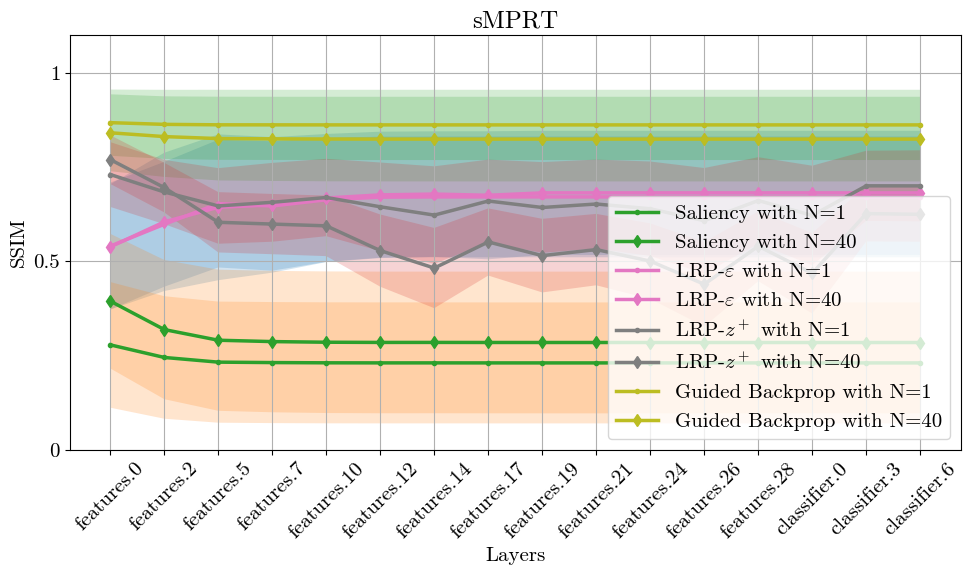

{'eval_layer_order': 'top_down', 'model_name': 'vgg16'}


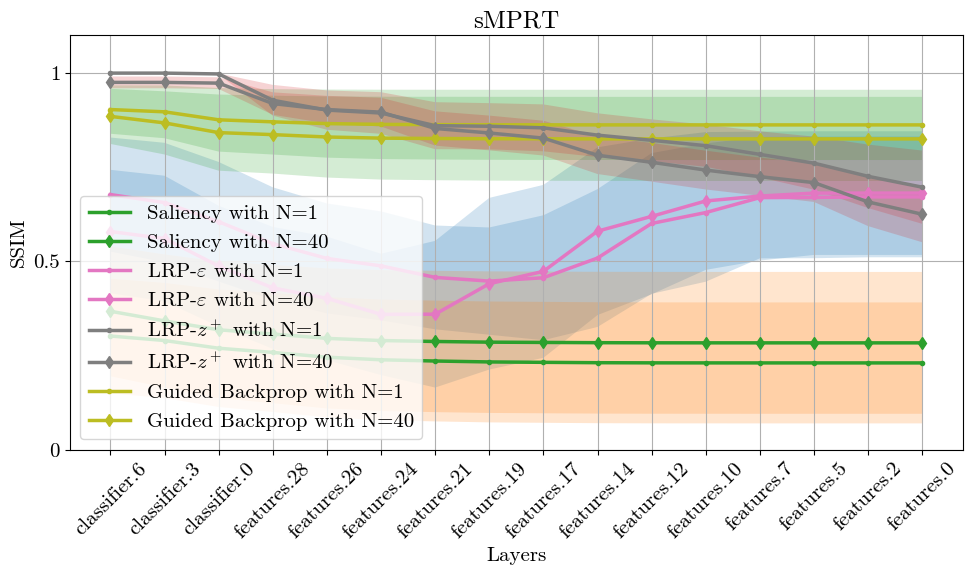

In [6]:
selection_filters = [{"eval_metricname": "smprt"}]
plotted_xai_n_noisedraws = [1, 40]

# Iterate through filters
for selection_filter in selection_filters:
    selected_runs = select_runs(scores, selection_filter)
    selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]
    for bpf in between_plot_filters:
        bpf_runs = select_runs(selected_runs, bpf)

        print(bpf)
        fname = f"smprt-lineplot-imagenet"
        for k, v in bpf.items():
            fname += f"-{v}"
        filepath = os.path.join(figurepath, fname+".svg")
        plot_mprt_lineplot(bpf_runs, "explanation_scores", "sMPRT", "SSIM", within_plot_filters, filepath)


### eMPRT - Line Plots

{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16'}


/tmp/ipykernel_366725/3620474442.py:22: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))


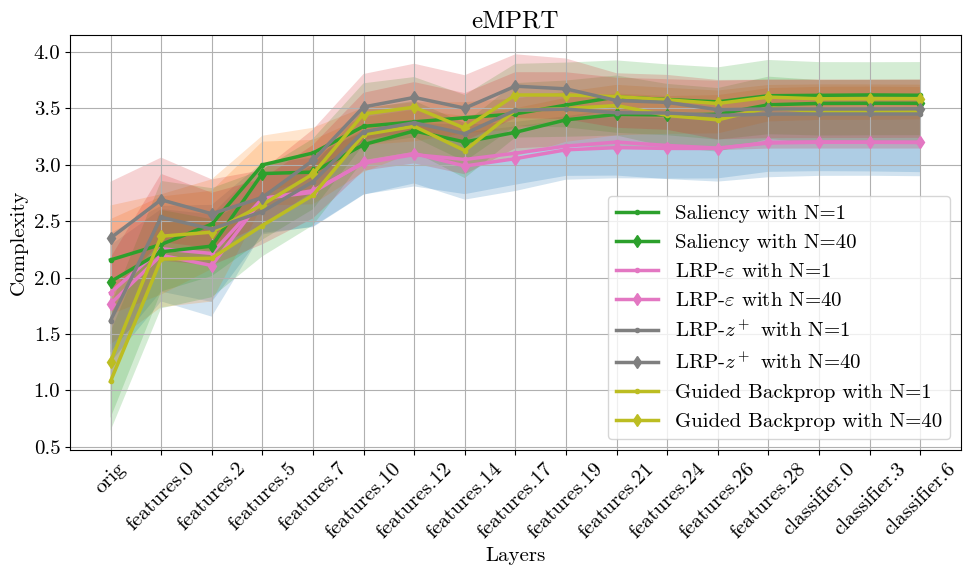

{'eval_layer_order': 'top_down', 'model_name': 'vgg16'}


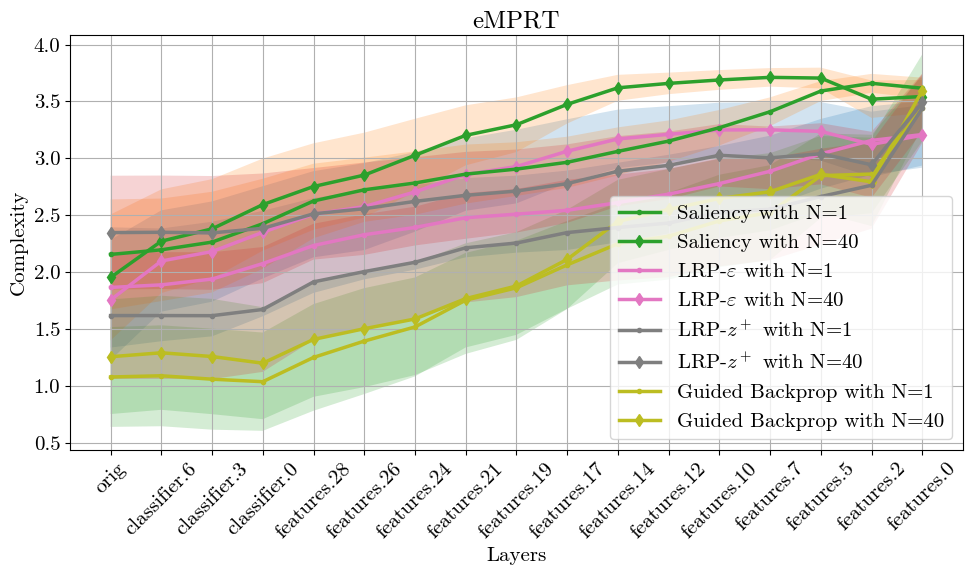

In [7]:
selection_filters = [{"eval_metricname": "emprt"}]
plotted_xai_n_noisedraws = [1, 40]

# Iterate through filters
for selection_filter in selection_filters:
    selected_runs = select_runs(scores, selection_filter)
    selected_runs = [(c, r) for c, r in selected_runs if c["xai_n_noisedraws"] in plotted_xai_n_noisedraws]
    for bpf in between_plot_filters:
        bpf_runs = select_runs(selected_runs, bpf)

        print(bpf)
        fname = f"emprt-lineplot-imagenet"
        for k, v in bpf.items():
            fname += f"-{v}"
        filepath = os.path.join(figurepath, fname+".svg")
        plot_mprt_lineplot(bpf_runs, "explanation_scores", "eMPRT", "Complexity", within_plot_filters, filepath)

### sMPRT vs. eMPRT - Twine Plots

38
{'eval_layer_order': 'bottom_up', 'model_name': 'vgg16'}


/tmp/ipykernel_366725/3620474442.py:95: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
/tmp/ipykernel_366725/3620474442.py:104: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax2 = ax1.twinx()
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/work-code/Quantus/quantus/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-d

UnboundLocalError: local variable 'c' referenced before assignment

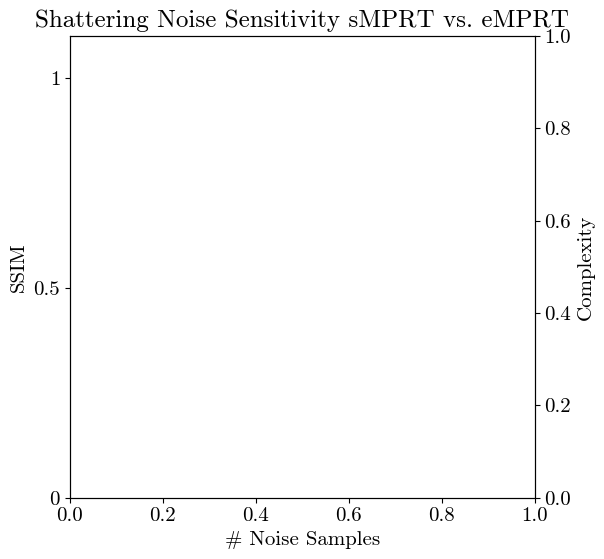

In [9]:

selection_filters = [{"eval_metricname": "smprt"}, {"eval_metricname": "emprt"}]
plotted_xai_methods = ["gradient", "lrp-zplus"]

# Iterate through filters
selected_runs = [select_runs(scores, selection_filter) for selection_filter in selection_filters]
selected_runs = [[(c, r) for c, r in selected_run if c["xai_methodname"] in plotted_xai_methods] for selected_run in selected_runs]

print(len(selected_runs[0]))

for bpf in between_plot_filters:
    bpf_runs = [select_runs(selected_run, bpf) for selected_run in selected_runs]

    print(bpf)
    fname = f"smprt-emprt-twinplot-imagenet"
    for k, v in bpf.items():
        fname += f"-{v}"
    filepath = os.path.join(figurepath, fname+".svg")
    plot_twinplot(bpf_runs[0], bpf_runs[1], "explanation_scores", "fraction_explanation_scores", "Shattering Noise Sensitivity sMPRT vs. eMPRT", "SSIM", "Complexity", within_plot_filters, filepath)